In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path
import xarray as xr
import rioxarray
from rioxarray.merge import merge_arrays
import xdem
import tempfile
import numpy as np
from matplotlib import colors
import leafmap.leafmap as leafmap
from pysheds.grid import Grid

CRS_ARGENTINA = "EPSG:5349"
CRS_WGS84 = "EPSG:4326"

RUTA_BASE = Path("/home/nissim/Documents/dev/fulbright/ciut-riesgo")
RUTA_DATOS = RUTA_BASE / "notebooks/data"
RUTA_PARTIDOS = RUTA_DATOS / "pba_partidos.geojson"

CMAP = "Blues"

partidos = gpd.read_file(RUTA_PARTIDOS)
partidos = partidos.to_crs(CRS_ARGENTINA)
la_plata = partidos[partidos["fna"] == "Partido de La Plata"]

# Quitar la isla de La Plata - mantener solo el polígono más grande
geometria_principal = la_plata.geometry.iloc[0]
if geometria_principal.geom_type == "MultiPolygon":
    poligono_mayor = max(geometria_principal.geoms, key=lambda p: p.area)
    la_plata = la_plata.copy()
    la_plata.loc[la_plata.index[0], "geometry"] = poligono_mayor

bbox_la_plata_4326 = la_plata.to_crs(CRS_WGS84).total_bounds

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

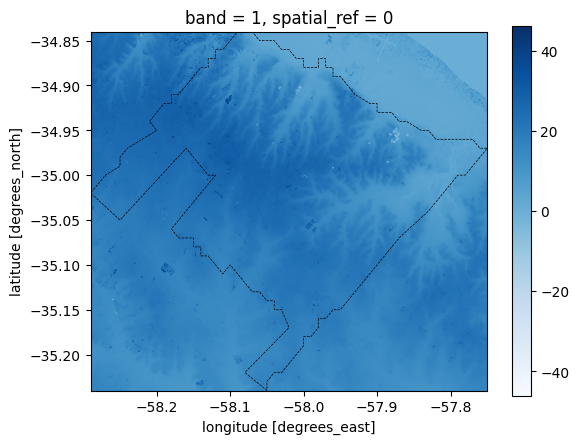

In [2]:
rutas_tiles = [
    RUTA_DATOS / "fabdem/S40W060-S30W050_FABDEM_V1-2/S35W058_FABDEM_V1-2.tif",
    RUTA_DATOS / "fabdem/S40W060-S30W050_FABDEM_V1-2/S36W058_FABDEM_V1-2.tif",
    RUTA_DATOS / "fabdem/S40W060-S30W050_FABDEM_V1-2/S35W059_FABDEM_V1-2.tif",
    RUTA_DATOS / "fabdem/S40W060-S30W050_FABDEM_V1-2/S36W059_FABDEM_V1-2.tif",
]

tiles = [rioxarray.open_rasterio(path, chunks=True) for path in rutas_tiles]
dem_fusionado = merge_arrays(tiles)

dem_recortado = dem_fusionado.rio.clip_box(
    minx=bbox_la_plata_4326[0],
    miny=bbox_la_plata_4326[1],
    maxx=bbox_la_plata_4326[2],
    maxy=bbox_la_plata_4326[3],
)

dem_recortado.plot(cmap=CMAP)
ax = plt.gca()
la_plata_wgs84 = la_plata.to_crs(CRS_WGS84)
la_plata_wgs84.plot(
    ax=ax,
    facecolor="none",
    edgecolor="black",
    linewidth=0.5,
    linestyle="--",
    zorder=5,
)

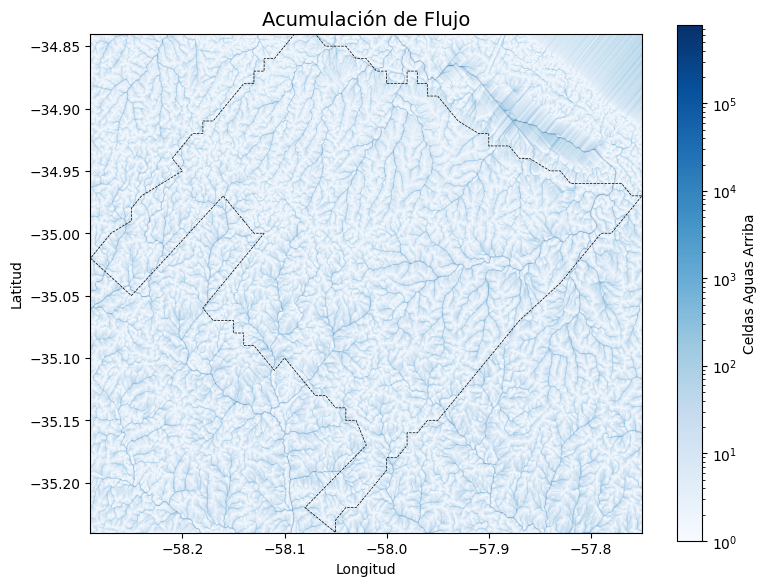

In [3]:
with tempfile.NamedTemporaryFile(suffix=".tif", delete=False) as tmp_file:
    ruta_temporal = tmp_file.name


dem_recortado.rio.to_raster(ruta_temporal)
grilla = Grid.from_raster(ruta_temporal)

dem = grilla.read_raster(ruta_temporal)

valor_nodata = dem_recortado.attrs.get("_FillValue", -9999.0)

# Acondicionar DEM
dem_pozos_rellenos = grilla.fill_pits(dem)
dem_inundado = grilla.fill_depressions(dem_pozos_rellenos)
dem_inflado = grilla.resolve_flats(dem_inundado)


dem_inflado_xarray = xr.DataArray(
    dem_inflado,
    coords={"y": dem_recortado.y, "x": dem_recortado.x},
    dims=["y", "x"],
    attrs=dem_recortado.attrs,
).rio.write_crs("EPSG:4326")


mapa_direcciones = (64, 128, 1, 2, 4, 8, 16, 32)


direcciones_flujo = grilla.flowdir(
    dem_inflado, dirmap=mapa_direcciones, nodata_out=np.int32(0)
)

direcciones_flujo_xarray = xr.DataArray(
    direcciones_flujo,
    coords={"y": dem_recortado.y, "x": dem_recortado.x},
    dims=["y", "x"],
    attrs=dem_recortado.attrs,
).rio.write_crs("EPSG:4326")


acumulacion = grilla.accumulation(
    direcciones_flujo, dirmap=mapa_direcciones, nodata_out=np.int32(0)
)


acumulacion_xarray = xr.DataArray(
    acumulacion,
    coords={"y": dem_recortado.y, "x": dem_recortado.x},
    dims=["y", "x"],
    attrs=dem_recortado.attrs,
).rio.write_crs("EPSG:4326")

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
plt.grid("on", zorder=0)
im = ax.imshow(
    acumulacion,
    extent=grilla.extent,
    zorder=2,
    cmap=CMAP,
    norm=colors.LogNorm(1, acumulacion.max()),
    interpolation="bilinear",
)
plt.colorbar(im, ax=ax, label="Celdas Aguas Arriba")

la_plata_wgs84.plot(
    ax=ax,
    facecolor="none",
    edgecolor="black",
    linewidth=0.5,
    linestyle="--",
    zorder=5,
)
plt.title("Acumulación de Flujo", size=14)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.tight_layout()

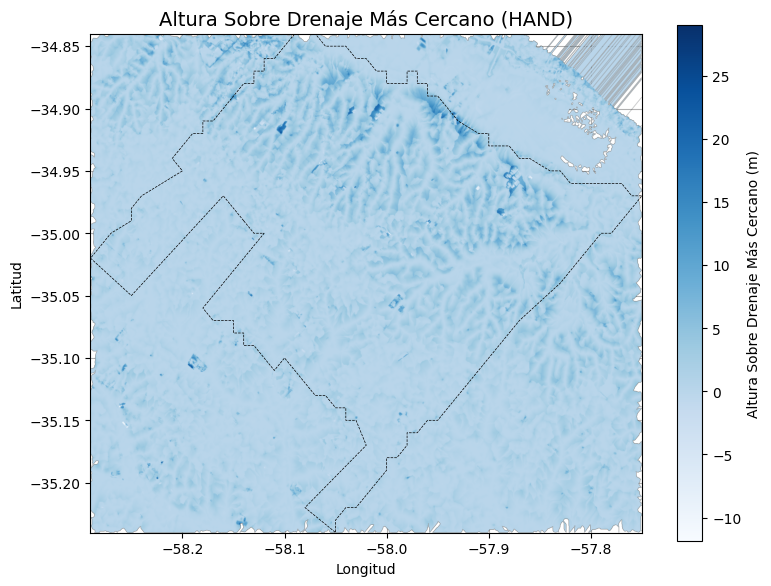

In [4]:
hand = grilla.compute_hand(
    direcciones_flujo, dem, acumulacion > 200, nodata_value=np.int32(0)
)

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
plt.grid("on", zorder=0)
im = ax.imshow(
    hand,
    extent=grilla.extent,
    zorder=2,
    cmap=CMAP,
    interpolation="bilinear",
)
plt.colorbar(im, ax=ax, label="Altura Sobre Drenaje Más Cercano (m)")

la_plata_wgs84.plot(
    ax=ax,
    facecolor="none",
    edgecolor="black",
    linewidth=0.5,
    linestyle="--",
    zorder=5,
)

plt.title("Altura Sobre Drenaje Más Cercano (HAND)", size=14)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.tight_layout()
plt.show()

<Axes: xlabel='x', ylabel='y'>

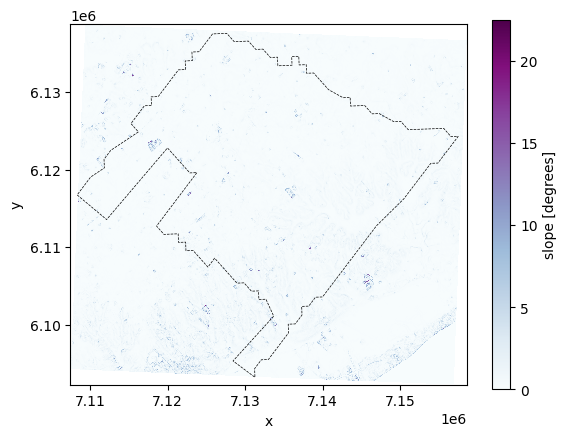

In [5]:
with tempfile.NamedTemporaryFile(suffix=".tif", delete=False) as tmp_file:
    ruta_temporal = tmp_file.name

# Reproyectar con resolución y proyeccion explícita igual
dem_reproyectado = dem_recortado.rio.reproject(
    CRS_ARGENTINA,
    resolution=30,
)

dem_reproyectado.rio.to_raster(ruta_temporal)
dem = xdem.DEM(ruta_temporal)

atributos = xdem.terrain.get_terrain_attribute(
    dem.data,
    resolution=dem.res,
    attribute=[
        "hillshade",
        "slope",
        "aspect",
        "curvature",
        "terrain_ruggedness_index",
        "rugosity",
    ],
)

datos_pendiente = atributos[1]

coordenadas_y = np.arange(dem.bounds.bottom, dem.bounds.top, dem.res[1])
coordenadas_x = np.arange(dem.bounds.left, dem.bounds.right, dem.res[0])

pendiente_xarray = xr.DataArray(
    datos_pendiente,
    coords={"y": coordenadas_y, "x": coordenadas_x},
    dims=["y", "x"],
    attrs={"crs": dem.crs, "units": "degrees", "long_name": "slope"},
)

pendiente_xarray.plot(cmap=CMAP)
ax = plt.gca()
la_plata.plot(
    ax=ax,
    facecolor="none",
    edgecolor="black",
    linewidth=0.5,
    linestyle="--",
    zorder=5,
)

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

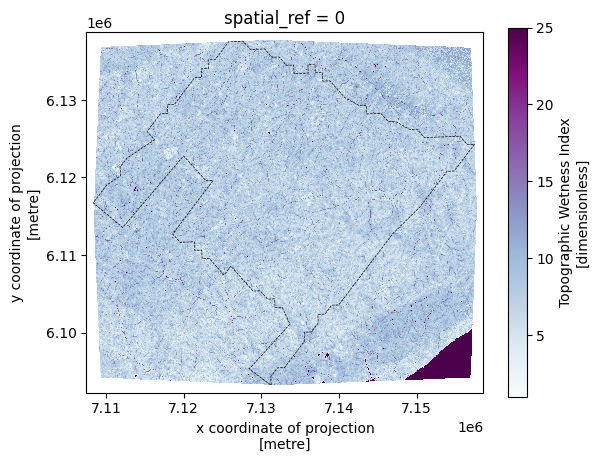

In [6]:
acumulacion_xarray_reproyectada = acumulacion_xarray.rio.reproject(CRS_ARGENTINA)

# Remuestrear pendiente para coincidir con acumulación
pendiente_remuestreada = pendiente_xarray.rio.reproject(
    acumulacion_xarray_reproyectada.rio.crs,
    shape=acumulacion_xarray_reproyectada.shape,
    transform=acumulacion_xarray_reproyectada.rio.transform(),
)

pendiente_rad = np.radians(pendiente_remuestreada)
datos_twi = np.log(acumulacion_xarray_reproyectada / np.tan(pendiente_rad))

# Then handle extreme values for visualization/analysis
datos_twi = np.where(np.isinf(datos_twi), 25, datos_twi)
datos_twi = np.where(datos_twi > 25, 25, datos_twi)

twi_xarray = xr.DataArray(
    datos_twi,
    coords=acumulacion_xarray_reproyectada.coords,
    dims=acumulacion_xarray_reproyectada.dims,
    attrs={
        "crs": acumulacion_xarray_reproyectada.rio.crs,
        "units": "dimensionless",
        "long_name": "Topographic Wetness Index",
        "description": "ln(flow_accumulation / tan(slope + 0.0001))",
    },
)

plt.figure()
twi_xarray.plot(cmap=CMAP)
ax = plt.gca()
la_plata.plot(
    ax=ax,
    facecolor="none",
    edgecolor="black",
    linewidth=0.5,
    linestyle="--",
    zorder=5,
)

In [15]:
# Cargar datos de peligro
ruta_peligro = RUTA_DATOS / "peligro_raster_10m.tif"
peligro_xarray = rioxarray.open_rasterio(ruta_peligro)

la_plata_centroid = la_plata.to_crs(CRS_WGS84).centroid.iloc[0]
center_lat = la_plata_centroid.y
center_lon = la_plata_centroid.x

m = leafmap.Map(center=[center_lat, center_lon], zoom=9)
m.add_tile_layer(
    url="https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}",
    name="Google Satellite",
    attribution="Google",
)

mask = twi_xarray.rio.clip(la_plata.geometry, la_plata.crs, drop=False, invert=False)
mask = xr.where(~mask.isnull(), 1, 0)
twi_masked = xr.where(mask == 1, twi_xarray, np.nan)
twi_masked = twi_masked.rio.write_crs(twi_xarray.rio.crs)
twi_masked = twi_masked.rio.write_transform(twi_xarray.rio.transform())

# Jenks breaks classification with sampling
from jenkspy import jenks_breaks
twi_valid = twi_masked.values[~np.isnan(twi_masked.values)]
sample_size = min(10000, len(twi_valid))
twi_sample = np.random.choice(twi_valid, size=sample_size, replace=False)
breaks = jenks_breaks(twi_sample, n_classes=4)
twi_jenks = xr.where(twi_masked <= breaks[1], 1,
                     xr.where(twi_masked <= breaks[2], 2,
                              xr.where(twi_masked <= breaks[3], 3, 4)))
twi_jenks = xr.where(~twi_masked.isnull(), twi_jenks, np.nan)
twi_jenks = twi_jenks.rio.write_crs(twi_xarray.rio.crs)
twi_jenks = twi_jenks.rio.write_transform(twi_xarray.rio.transform())

peligro_2d = peligro_xarray.sel(band=1).astype('float32')
peligro_clipped = peligro_2d.rio.clip(la_plata.geometry, la_plata.crs)

m.add_raster(twi_masked, colormap=CMAP, layer_name="TWI", nodata=np.nan)
m.add_raster(twi_jenks, colormap=CMAP, layer_name="TWI Jenks (4 classes)", nodata=np.nan)
m.add_raster(peligro_clipped, colormap=CMAP, layer_name="Peligrosidad", nodata=peligro_clipped.rio.nodata)

la_plata_geojson = la_plata.to_crs(CRS_WGS84).__geo_interface__
m.add_geojson(
    la_plata_geojson,
    layer_name="Partido de La Plata",
    style={"color": "black", "weight": 2, "fillOpacity": 0},
)

m.add_layer_control()
m

Map(center=[-35.040972499999995, -58.0228485], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…